In [45]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import  mean_absolute_error as mae
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [6]:
path='https://github.com/dataworkshop/5dwchallenge_2019/blob/master/challenge5/input/visits.csv?raw=true'
df=pd.read_csv(path,parse_dates=['published'],index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


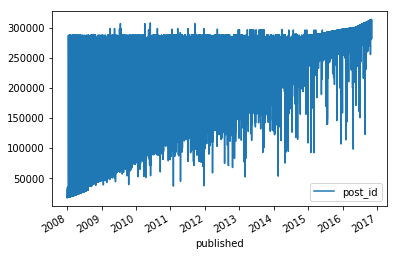

In [9]:
df.plot();

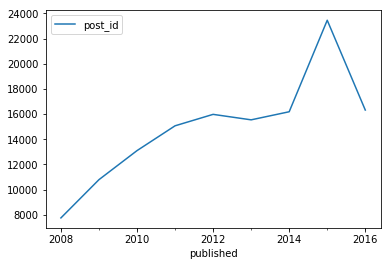

In [14]:
df.resample('1y').count().plot();#per rok

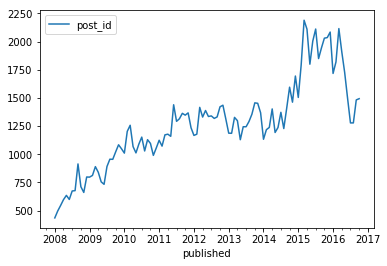

In [15]:
df.resample('1m').count().plot();#per miesiąc

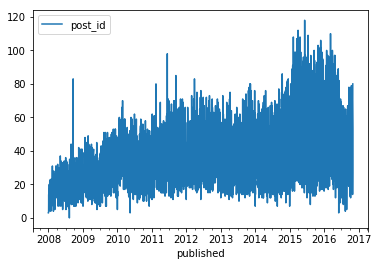

In [16]:
df.resample('1d').count().plot();#per dzien

In [19]:
df_day=df.resample('1d').count().reset_index()
df_day.columns=['ds','y']
df_day.head()

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4


In [48]:
num_points_to_pred=100
train=df_day[:-num_points_to_pred]
test=df_day[-num_points_to_pred:]

In [49]:
m=Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\jokes\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [50]:
future=m.make_future_dataframe(periods=num_points_to_pred,freq='D',include_history=False)
future.head()

,ds
0,2016-07-24
1,2016-07-25
2,2016-07-26
3,2016-07-27
4,2016-07-28


In [51]:
forecast=m.predict(future)

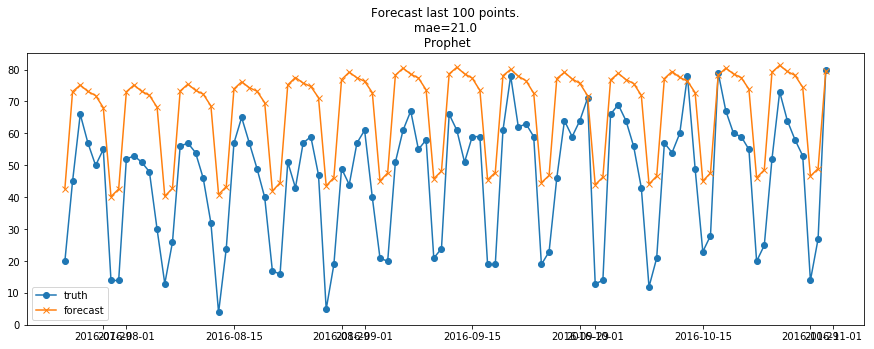

In [52]:
def plot_forecast(test, forecast):
    forecast=forecast[-num_points_to_pred:]
    score=np.round(mae(test.y, forecast.yhat))
    plt.figure(figsize=(15,5))
    plt.title('Forecast last {} points.\n mae={} \n Prophet'.format(num_points_to_pred, score))
    plt.plot(test.ds,test.y, 'o-',label='truth')
    plt.plot(test.ds, forecast.yhat,'x-', label='forecast')
    plt.legend()

plot_forecast(test, forecast)

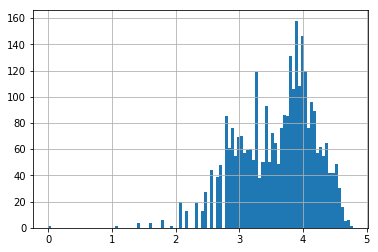

In [55]:
np.log1p(train.y).hist(bins=100);

In [56]:
num_points_to_pred=100
train=df_day[:-num_points_to_pred]
test=df_day[-num_points_to_pred:]

train_log=train.copy()
train_log['y']=np.log1p(train_log['y'])

In [60]:
m=Prophet(changepoint_prior_scale=0.01)
m.fit(train_log)
future=m.make_future_dataframe(periods=num_points_to_pred,freq='D',include_history=False)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\jokes\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



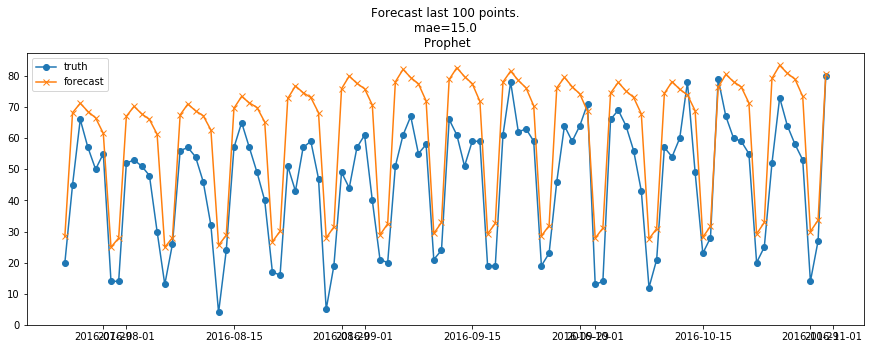

In [64]:
forecast=m.predict(future)
forecast['yhat']=np.expm1(forecast.yhat)
plot_forecast(test, forecast)

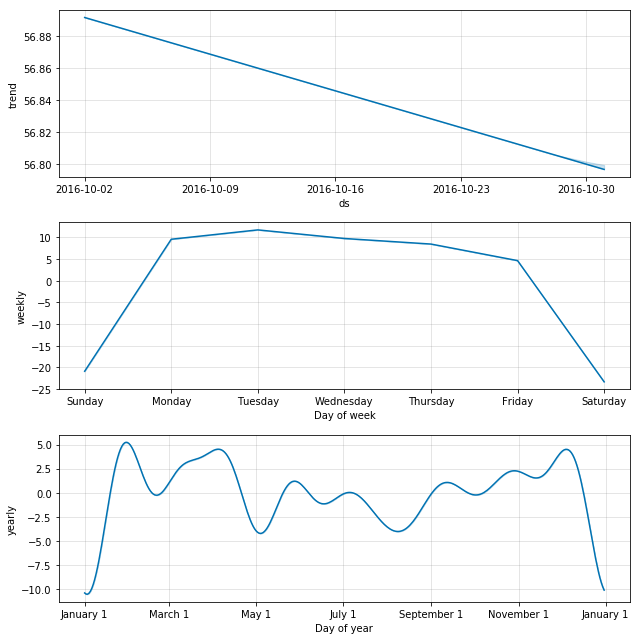

In [37]:
m.plot_components(forecast);

In [39]:
len(train), len(test)

(3197, 30)

In [40]:
df_cv= cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')


INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00
C:\Users\jokes\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [43]:
df_cv.shape

(2010, 6)

In [44]:
df_cv.groupby('cutoff').count().head()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30


In [46]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,370.282872,19.242736,16.271774,0.563967,0.432836
1,4 days,334.989938,18.302730,15.700967,0.435427,0.422886
2,5 days,346.539720,18.615577,15.814724,0.476772,0.442786
3,6 days,349.721051,18.700830,15.614186,0.460185,0.467662
4,7 days,377.767308,19.436237,16.167148,0.468468,0.442786
5,8 days,369.909938,19.233043,15.840256,0.437340,0.457711
6,9 days,360.971213,18.999242,15.717226,0.436183,0.447761
7,10 days,403.475245,20.086693,16.463171,0.471649,0.452736
8,11 days,416.550015,20.409557,16.683807,0.584836,0.447761
9,12 days,423.556784,20.580495,17.195017,0.587898,0.427861


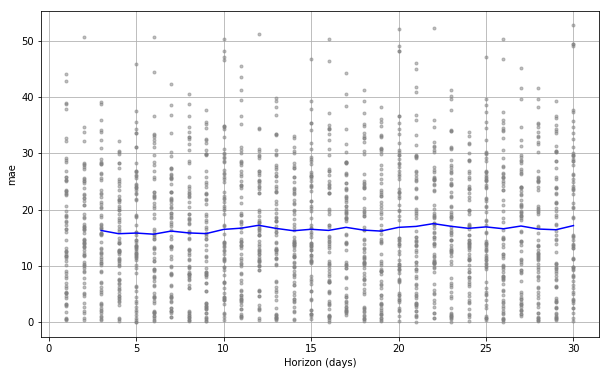

In [47]:
plot_cross_validation_metric(df_cv,'mae');